[View in Colaboratory](https://colab.research.google.com/github/luisflowers/ds_desafio_I/blob/master/Desafio_2_2_5.ipynb)

In [1]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1u2lMckjqMlD-7qXfV8i8MJiQm_6GbLX9'
downloaded = drive.CreateFile({'id': file_id})
# allows you to temporarily load your file in the notebook VM

# assume the file is called file.csv and it's located at the root of your drive
downloaded.GetContentFile('properatti.csv')

!pip install stop-words

!pip install regex

!pip install unidecode

    100% |████████████████████████████████| 993kB 9.6MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
  Running setup.py bdist_wheel for stop-words ... - done
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
    100% |████████████████████████████████| 235kB 7.9MB/s 


In [0]:

% matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


from sklearn.feature_extraction import DictVectorizer


from scipy.sparse import hstack


from stop_words import get_stop_words
import unidecode
import re

excluyoZonas=False
tomoSampleo=True
columnasToDummy = ['property_type']
columnasToFill = [ 'property_type','new_usd_per_m2','place_name','rooms','surface_total_in_m2','surface_covered_in_m2','floor']
columnasFilled = [ 'rooms_filled','surface_total_in_m2_filled']

In [0]:
df = pd.read_csv('./properatti.csv')  # Dataset de PROPERATI
### si descomento tengo un conjunto acotado
#if (tomoSampleo):
#    df =df[:65000]
if(excluyoZonas):
    df_zonas_count = df.groupby(by='place_with_parent_names').agg({'property_type':'count'})
    ### obtengo las zonas que tengan pocos elementos. Si tengo mas features que elementos no sirve
    ### para clasificar.
    ### no se que hacer!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    df_zonas_count=df_zonas_count[df_zonas_count['property_type'] <df_zonas_count['property_type'].std()*1.5 ].index



## obtengo todas las zonas que tengan menos de 1.5desvios en propiedades por tipo
### si tengo muchos features caracteristicos de una zona con peso no me sirve para pocas zonas
### en cambio si quiero hacerlo para todos tengo que empezar a sacar features

# ES PARA REVISAR

In [0]:
if (excluyoZonas):
    df=df[df['place_with_parent_names'].isin(pd.DataFrame(df_zonas_count)['place_with_parent_names'])] 
    #df[~df['place_with_parent_names']]
    print('Quedaron',df.shape[0],' propiedades')

In [0]:
### La funcion de Luis con un cambio 
### Cambio : 10/9 - Leo
### A los nans les imputo 0 (de otra forma lo hubiera hecho mas adelante cuando a los nan los reemplazaba por 0)
### no aplico solo a un grupo estrecho sin los outliers.
### aplico a la mediana con los outliers.
def imputoPrecio(dfTmp):

    #Obtenemos un dataframe con los valores dummies del tipo de moneda
    dummies_price = pd.get_dummies(dfTmp['currency'])
    #Filtramos en una nueva columna los valores que están en ARS
    dfTmp["ars"] = dfTmp["price"] * dummies_price["ARS"]
    #dummies_price["ARS"].value_counts()
    #Calculamos el valor aproximado del USD según los precios que están en pesos "ars"
    #y que tienen el precio aproximado en USD en la columna "price_aprox_usd" y lo guardamos
    #en una nueva columna "USDaprox"
    dfTmp["USDaprox"] = dfTmp["ars"] / (df["price_aprox_usd"] * dummies_price["ARS"])

    #Encontramos el valor que se utiliza en la mediana de los casos para el dólar
    # y así trabajar con este valor para las aproximaciones que hagan falta
    #df["USDaprox"].median()
    #Calculamos el valor aproximado del USD según los precios que están en pesos "ars"
    #y que tienen el precio aproximado en USD en la columna "price_aprox_usd" y lo guardamos
    #en una nueva columna "USDaprox"
    #Armamos un nuevo array donde vamos a imputar los precios por M2 en USD de forma que
    #podamos usarlo como valorizador. Lo llenamos en principio con los valores de price_usd_per_m2
    USD = df["USDaprox"].median()
    
    y = df["price_per_m2"].fillna(0)/USD
    dfTmp["new_usd_per_m2"] = dfTmp["price_usd_per_m2"].fillna(y)
    return dfTmp

In [0]:
### dada una lista de dummy definida arriba la convierto a dummy .
### el flag de sparse no funciona.
def setMatricesDummy(columnas,dfTmp,esSparse):
    frames = []
    for i in columnas:
        frames.append( pd.get_dummies( dfTmp[i ],sparse=esSparse))
    pdCompleto=pd.concat(frames,axis=1,join='outer')
    
    return pdCompleto

#dfFilled.columns
#dfFeaturesFromTitle.columns
#dfDummy.columns

In [0]:
### defino la lista de palabras que no contamos con el count vectorizer
def getStopWords():
    stop_words=get_stop_words('spanish')
    stop_words_xl = [',',':','!','/','$','+','?','|','!!','!!!','$','+','-','//',' ','ambientes','ph','departamento','casa','.','argentina','u$d','u$s','venta','vende','vendo','amb','ambiente','ambientes','u$s','u$d']
    return stop_words + stop_words_xl + df['place_name'].apply(lambda x:(str(x).lower())).tolist() +df['country_name'].apply(lambda x:(str(x).lower())).tolist() +df['state_name'].apply(lambda x:(str(x).lower())).tolist() 
### diccionario de palabras que descubrio count vectorizer. finalmente no uso el diccionario 
### sirve para ver que hay
def getDictFeatures():
    return [
    {'feature': 'acceso'},
    {'feature': 'subte'},
    {'feature': 'amplia'},
    {'feature': 'amplia'},
    {'feature': 'amplio'},
    {'feature': 'amplios'},
    {'feature': 'avenida'},
    {'feature': 'balcon'},
    {'feature': 'bano'},
    {'feature': 'bano completo'},
    {'feature': 'calefaccion'},
    {'feature': 'cochera'},
    {'feature': 'cocheras'},
    {'feature': 'cocina'},
    {'feature': 'cocina comedor'},
    {'feature': 'cocina integrada'},
    {'feature': 'comedor'},
    {'feature': 'comercial'},
    {'feature': 'complejo'},
    {'feature': 'dependencia'},
    {'feature': 'baulera'},
    {'feature': 'lavadero'},
    {'feature': 'living comedor'},
    {'feature': 'jardin'},
    {'feature': 'luminoso'},
     {'feature': 'madera'},
    {'feature': 'patio'},
    {'feature': 'parrilla'},    
     {'feature': 'parque'},
    {'feature': 'jardin'},
    {'feature': 'luminoso'},
     {'feature': 'placard'},
    {'feature': 'piscina'},
    {'feature': 'pileta'},
        {'feature': 'quincho'},
    {'feature': 'suite'},
        {'feature': 'terraza'},
    {'feature': 'toilet'}
]
### borro numeros en el analisis de palabras. no quiero valores numericos que le pongo al modelo 
### por otro lado.
def dropNumero(x):
    p = re.compile(r'\d')
    if (bool(p.search(x))):
        return ''
    else:
        return x
### saco acentos
def sacoAcentos(s):
    return unidecode.unidecode(s)
### convierto oraciones a listas de palabras
### de vuelta saco los numeros y los reemplazo por una palabra clave 
def getTexto(col):
    return col.replace('\d+', '|NUM|', regex=True).apply(lambda x:sacoAcentos(x)).apply(lambda x:(x.lower().replace('.','').split()))
    
def getPlaces(dfTmp):
    return dfTmp['place_with_parent_names'].apply(lambda x:x.split('|'))




def extraigoColsConValorNumericoDeFeatures(dfTmp):
    ## si hay un valor numerico en el titulo que muestra al model algun feature numerico de otra columna es un problema.
    ##mejor sacar
    col2drop =[]
    for i in dfTmp.columns:
        if ('num' in i):
            col2drop.append(i)
    dfTmp.drop(col2drop,axis=1,inplace=True)
    return dfTmp    

In [0]:

### tengo un df con caracteristicas del titulo - no lo uso porque uso uno que me devuelve un sparse
def getFeaturesFromTitle(dfTmp):
    stop_words=getStopWords()
    cvec=TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2),strip_accents=None, max_features=150,token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
    bag = cvec.fit_transform(getTexto(dfTmp['title']))
    
    #bag = cvec.fit_transform(dfTmp['title'].replace('\d+', '|NUM|', regex=True).apply(lambda x:sacoAcentos(x)).apply(lambda x:(x.lower().replace('.','').split())))
    #bag = cvec.fit_transform(dfTmp['title'].apply(lambda x:sacoAcentos(x)).apply(lambda x:(x.lower().replace('.','').split())))
    dfFeatures=pd.DataFrame(bag.T.toarray() ,cvec.get_feature_names())
    
    return extraigoColsConValorNumericoDeFeatures(dfFeatures.T)

### tengo un df con las ubicaciones
def getFeaturesFromPlaces(dfTmp):
    stop_words=getStopWords()
    cvec=TfidfVectorizer(ngram_range=(1,3),strip_accents=None, token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
    bag = cvec.fit_transform(getPlaces(dfTmp))
    dfFeatures=pd.DataFrame(bag.T.toarray() ,cvec.get_feature_names())
    return extraigoColsConValorNumericoDeFeatures(dfFeatures.T)


## tengo una sparse con las caracteristicas del titulo
def getFeaturesFromTitleSparse(dfTmp):
    stop_words=getStopWords()
    cvec=TfidfVectorizer(stop_words=stop_words,ngram_range=(1,1),strip_accents=None, max_features=25,token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
    pipeline=Pipeline([('vect',cvec),
                      #('tfidf',TfidfTransformer(use_idf=True,smooth_idf=True)),
                      #('clf',MultinomialNB(alpha=1))
                      ])
    return pipeline.fit_transform(getTexto(dfTmp['title']))
def getFeaturesFromTitleSparse2(dfTmp):
    stop_words=getStopWords()
    cvec=CountVectorizer(stop_words=stop_words,ngram_range=(1,1),strip_accents=None, max_features=5,token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
    pipeline=Pipeline([('vect',cvec),
                      ('tfidf',TfidfTransformer(use_idf=True,smooth_idf=True)),
                      ('clf',MultinomialNB(alpha=1))
                      ])
    return pipeline.fit_transform(dfTmp['title'])


## tengo una sparse con las ubicaciones    
def getFeaturesFromPlacesSparse(dfTmp):
    stop_words=getStopWords()
    cvec=CountVectorizer(ngram_range=(1,3),strip_accents=None, token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
    pipeline=Pipeline([('vect',cvec),
                      #('tfidf',TfidfTransformer(use_idf=True,smooth_idf=True)),
                      #('clf',MultinomialNB(alpha=1))
                      ])
    return pipeline.fit_transform(getPlaces(dfTmp))
    



## armo columnas copiando el valor original donde le pongo un filler(0) a los nans.
## la lista de columnas la paso arriba.
def agregoColumnasConFlagNaN(columnas,dfTmp,filler):
    for i in columnas:
        dfTmp[i + '_filled'] = dfTmp[i].fillna(filler)
    return dfTmp

In [0]:
### normalizo precio.
### todavia no se sirve pero la teoria parece indicar que si para evitar la dispersion 
## que observamos en desafio I

def normalizoPrice(dfTmp):
    from sklearn.preprocessing import FunctionTransformer
    # Instancio el Optimus Prime con log1p
    transformer = FunctionTransformer(np.log1p)
    price = dfTmp['new_usd_per_m2'].values
    return transformer.transform([price])[0]



In [0]:
### convierto la escala de los de la lista
### rooms y m2.

def conviertoEscala(dfTmp,columnas):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import scale
    minmaxscaler_model = MinMaxScaler()
    return minmaxscaler_model.fit_transform(dfTmp[columnas])

In [38]:
getFeaturesFromPlacesSparse(df)

<121220x5653 sparse matrix of type '<class 'numpy.int64'>'
	with 1424141 stored elements in Compressed Sparse Row format>

## obtengo mis x -> matriz
## y -> precio

In [0]:
### Termine de definir las funciones auxiliares 
### obtengo el x e y

#frames = [dfFilled,dfPrecioImputado,dfFeaturesFromTitle,dfDummy]
df = imputoPrecio(df)
df = agregoColumnasConFlagNaN(columnasToFill,df,0)
dfEscala = conviertoEscala(df,columnasFilled)
### new_usd_per_m2_filled
#precios = df.iloc[:,30:31]
### new_usd_per_m2
#precios = df.iloc[:,28:29]

### obtengo la matriz  X
### DUMMY DE TIPO DE PROP, sparse de UBICACION Y TITULO y M2 TOTAL Y ROOMS en escala 
matriz = hstack([getFeaturesFromPlacesSparse(df),
                 #getFeaturesFromTitleSparse(df),
                 #setMatricesDummy(columnasToDummy,df,True),
                 conviertoEscala(df,columnasFilled)
                ])

#display(matriz.shape)
#matriz.shape

#from sklearn.preprocessing import Imputer
#imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
#precios = imp.fit_transform(precios)x=normalizoPrice(df)

#### Aca tengo mis Y

precios=normalizoPrice(df)


#dfCompleto=pd.concat(frames,axis=1,join='outer')

In [0]:

#columnas = ['place_name','rooms','surface_total_in_m2','surface_covered_in_m2','floor']

In [0]:
#getFeaturesFromTitle(df).to_csv('properati_featurizado.csv', sep=',', encoding='utf-8')

#df2.columns

## 2da PARTE

In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [0]:
#dfPrecioImputadoColumnsDel=['Unnamed: 0', 'operation', 'property_type', 'place_name',
#       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
#       'lat-lon', 'lat', 'lon', 'price', 'currency',
#       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
#       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
#       'rooms', 'expenses', 'properati_url', 'description', 'title',
#       'image_thumbnail', 'ars', 'USDaprox', 'new_usd_per_m2','property_type_filled', 'place_name_filled', ]
#dfCompleto.drop(dfPrecioImputadoColumnsDel,inplace=True,axis=1)

In [14]:
#precios=precios[precios['new_usd_per_m2_filled']<200000]
precios


array([7.02844318, 0.        , 7.17785181, ..., 5.27425315, 7.72539668,
       4.79921399])

In [40]:
y= precios
df = matriz
type(df)

scipy.sparse.coo.coo_matrix

In [0]:
#dfSample = dfCompleto.sample(10)

In [41]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
display (X_train.shape, y_train.shape)
display (X_test.shape, y_test.shape)

(96976, 5655)

(96976,)

(24244, 5655)

(24244,)

In [0]:

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
model_bic = LassoLarsIC(criterion='bic')
#model_bic.fit(matriz.toarray(), precios)
#alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
#model_aic.fit(matriz.toarray(),precios)
#alpha_aic_ = model_aic.alpha_

#display(alpha_bic_,alpha_aic_)

# Tengo x e y
# Vamos jugando con los modelos

In [0]:

# fit a model
#lm = linear_model.LinearRegression(fit_intercept=True,normalize=True)
lm = linear_model.Lasso(alpha=0.0008)
#lm = linear_model.Ridge(alpha=0.8)
#lm=linear_model.ElasticNet(alpha=0.01)



model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [0]:
predictions[0:5]

array([6.60742029, 6.60742029, 3.83240326, 5.76198181, 5.07592828])

Text(0,0.5,'Predictions')

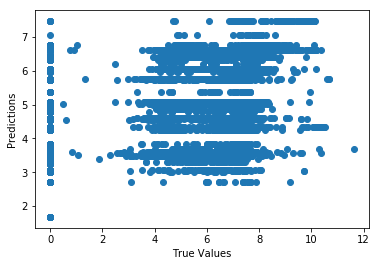

In [0]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions') 


In [0]:
print ('Score:', model.score(X_test, y_test))

Score: 0.04549159881537035


In [0]:
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=6) # Define the split - into 2 folds 
kf.get_n_splits(df) # returns the number of splitting iterations in the cross-validator

6

In [0]:
#for train_index, test_index in kf.split(df):
#    print('Train', train_index, 'Test', test_index)
#    X_train, X_test = df[train_index], df[test_index]
#    y_train, y_test = y[train_index], y[test_index]


In [17]:
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:

# Perform 6-fold cross validation
scores = cross_val_score(model, df, y, cv=6)
print ('Cross-validated scores:', scores)

Cross-validated scores: [-0.09086583  0.17271129  0.18953817  0.14795873  0.1712872   0.17869503]


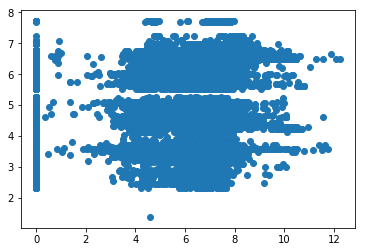

In [0]:
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=6)
plt.scatter(y, predictions)

In [0]:
accuracy = metrics.r2_score(y, predictions)
print (accuracy)

0.1455247203970481


# 3. Comparación Modelos

In [0]:
# Importamos librerías

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold # import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [0]:
# Generamos un grid de $\alpha$ para probar e instanciamos un particionador del Training Set 
# en K partes para realizar la validación cruzada

al_ridge = np.linspace(0.001, 20, 10)
al_lasso = np.linspace(0.1, 10, 10)
kf = KFold(n_splits=6, shuffle=True, random_state=12)

# Instanciamos los modelos

lm = LinearRegression(fit_intercept=True,normalize=True)
lmRidgeCV = RidgeCV(alphas=al_ridge, cv=kf, normalize=False)
lmLassoCV = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

## 3.1 Regresión lineal

In [0]:
# Entrenamos el modelo LM

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [46]:
# Hacemos cross validation

scores = cross_val_score(lm, X_train, y_train, cv=6, scoring='r2') 
scores, scores.mean()

(array([0.20580443, 0.20554925, 0.20787385, 0.2170759 , 0.21352648,
        0.2105874 ]), 0.21006955078181025)

## 3.2 Modelo Ridge

In [0]:
# Entrenamos el modelo Ridge

ridgemodel = lmRidgeCV.fit(X_train, y_train)

In [26]:
#Hacemos cross validation

scores = cross_val_score(ridgemodel, X_train, y_train, cv=6, scoring='r2')
dict(alpha=ridgemodel.alpha_, scores=scores, mean_score=scores.mean())

{'alpha': 15.555777777777775,
 'mean_score': 0.26752994582493345,
 'scores': array([0.26963522, 0.26019659, 0.28661914, 0.25489363, 0.26579637,
        0.26803873])}

In [27]:
print ("r^2:", ridgemodel.score(X_test, y_test))
print ("alpha:", ridgemodel.alpha_)

r^2: 0.2749794842700505
alpha: 15.555777777777775


## 3.3 Modelo Lasso

In [0]:
# Entrenamos el modelo Lasso

lassomodel = lmLassoCV.fit(X_train, y_train)

In [0]:
#Hacemos cross validation

scores = cross_val_score(lassomomodel, X_train, y_train, cv=6, scoring='r2')
dict(alpha=lassomodel.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

{'alpha': 0.1,
 'mean_score': 0.039844735076225324,
 'scores': array([0.0447771 , 0.03688315, 0.0449976 , 0.03764962, 0.03286014,
        0.04190081]),
 'zero_coefs': 222}

In [0]:
print ("r^2:", lassomodel.score(X_test, y_test))
print ("alpha:", lassomodel.alpha_)

r^2: 0.04273292504536353
alpha: 0.1


## 3.4 ElasticNet

In [28]:
elasticnet_model = linear_model.ElasticNet()

# Ajustamos nuevamente, esta vez con regularizacion

elasticnet_model = elasticnet_model.fit(X_train, y_train)
predictions = elasticnet_model.predict(X_test)

print ("r^2:", elasticnet_model.score(X_test, y_test))

r^2: -0.0004189215404966085
